In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from pettingzoo import ParallelEnv

num_agents = 10
num_rounds = 200
num_episodes = 500
b = 5           # Benefit
c = 1                    # Cost of cooperation

# Learning parameters
# chi = 10 / num_episodes    # Reputation assignment error
chi = 0.01

In [47]:
class MatrixGame(ParallelEnv):
    def __init__(self, reward_matrix, agents, norm, alpha=0.0):
        self.agents = agents 
        self.possible_agents = self.agents[:]
        self.reward_matrix = reward_matrix
        self.norm = norm
        self.last_opponent = {}
        self.actions = {}
        self.alpha = alpha

    def reset(self):
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0.0 for agent in self.agents}
        self.states = {agent: np.random.choice([0,1]) for agent in self.agents}

        return self.states
    
    def get_action_rules(self, action_rule):
        # Convert action_rule_id to 4-bits
        bits = [(action_rule >> i) & 1 for i in range(4)]  # bits[0]=LSB, bits[3]=MSB
        return bits
    

    def determine_state(self, focal_action, opponent_state):
        if focal_action == 0 and opponent_state == 0:
            return self.norm[3]  # Bit 3
        elif focal_action == 0 and opponent_state == 1:
            return self.norm[2]  # Bit 2
        elif focal_action == 1 and opponent_state == 0:
            return self.norm[1]  # Bit 1
        else:  # (1,1)
            return self.norm[0]  # Bit 0

    def step(self):
        pairings = []
        players = self.agents.copy()
        for _ in range(num_agents//2):
            index = random.randrange(len(players))
            elem1 = players.pop(index)

            index = random.randrange(len(players))
            elem2 = players.pop(index)

            pairings.append((elem1, elem2))


        for pair in pairings:
            action1 = pair[0].select_action(self.states[pair[1]])
            action2 = pair[1].select_action(self.states[pair[0]])

            self.actions[pair[0]] = action1
            self.actions[pair[1]] = action2

            self.last_opponent[pair[0]] = pair[1]
            self.last_opponent[pair[1]] = pair[0]

            reward1 = self.reward_matrix[action1][action2]
            reward2 = self.reward_matrix[action2][action1]

            # Calculate introspective reward
            intro_action1 = pair[0].select_action(self.states[pair[0]])
            intro_action2 = pair[1].select_action(self.states[pair[1]])

            intro_reward1 = self.reward_matrix[intro_action1][intro_action1]
            intro_reward2 = self.reward_matrix[intro_action2][intro_action2]


            self.rewards[pair[0]] = (1-self.alpha) * reward1 + self.alpha * intro_reward1 
            self.rewards[pair[1]] = (1-self.alpha) * reward2 + self.alpha * intro_reward2 


            state1 = self.determine_state(action1, self.states[pair[1]])
            state2 = self.determine_state(action2, self.states[pair[0]])

            if (random.random() < chi):
                state1 = 1-state1
            if (random.random() < chi):
                state2 = 1-state2

            self.states[pair[0]] = state1
            self.states[pair[1]] = state2

        return self.states, self.rewards, self.actions

In [48]:
class Qlearner:
    """A Q-learning agent"""

    def __init__(
        self,
        seeded=False,
        action_size=2,
        state_size=2,
        learning_rate=0.01,
        gamma=0.8,
        epsilon=0.1,
    ):
        self.action_size = action_size
        self.state_size = state_size

        self.seeded = seeded
        # initialize the Q-table: (State x Agent Action)
        self.qtable = np.zeros((self.state_size, self.action_size))

        self.learning_rate = learning_rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon # exploration

        # tracking rewards/progress:
        self.rewards_this_episode = []  # during an episode, save every time step's reward
        self.episode_total_rewards = []  # each episode, sum the rewards, possibly with a discount factor
        self.average_episode_total_rewards = []  # the average (discounted) episode reward to indicate progress

        self.state_history = []
        self.action_history = []

    def reset_agent(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

    def select_greedy(self, state):
        # np.argmax(self.qtable[state]) will select first entry if two or more Q-values are equal, but we want true randomness:
        return np.random.choice(np.flatnonzero(np.isclose(self.qtable[state], self.qtable[state].max())))

    def select_action(self, state):
        if self.seeded:
            return 5 
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            action = self.select_greedy(state)
        self.state_history.append(state)
        self.action_history.append(action)
        return action

    def update(self, state, action, new_state, reward, done):
        lr = self.learning_rate
        self.qtable[state, action] += lr * (reward + (not done) * self.gamma * np.max(self.qtable[new_state]) - self.qtable[state, action])

        self.rewards_this_episode.append(reward)

        if done:
            # track total reward:
            episode_reward = self._calculate_episode_reward(self.rewards_this_episode, discount=False)
            self.episode_total_rewards.append(episode_reward)

            k = len(self.average_episode_total_rewards) + 1  # amount of episodes that have passed
            self._calculate_average_episode_reward(k, episode_reward)
            
            # reset the rewards for the next episode:
            self.rewards_this_episode = []

    def _calculate_episode_reward(self, rewards_this_episode, discount=False):
        if discount:
            return sum([self.gamma**i * reward for i, reward in enumerate(rewards_this_episode)])
        return sum(rewards_this_episode)

    def _calculate_average_episode_reward(self, k, episode_reward):
        if k > 1:  # running average is more efficient:
            average_episode_reward = (1 - 1 / k) * self.average_episode_total_rewards[-1] + episode_reward / k
        else:
            average_episode_reward = episode_reward
        self.average_episode_total_rewards.append(average_episode_reward)

    def print_rewards(self, episode, print_epsilon=True, print_q_table=True):
        # print("Episode ", episode + 1)
        print("Total (discounted) reward of this episode: ", self.episode_total_rewards[episode])
        print("Average total reward over all episodes until now: ", self.average_episode_total_rewards[-1])

        print("Epsilon:", self.epsilon) if print_epsilon else None
        print("Q-table: ", self.qtable) if print_q_table else None

In [49]:
def run(payoffs, norm, alpha):
    run = 46
    np.random.seed(run)
    random.seed(run)

    agents = [Qlearner(seeded=True) for _ in range(0)] + [Qlearner(seeded=False) for _ in range(10)]
    env = MatrixGame(payoffs, agents, norm, alpha)
    print("Norm:", env.norm)

    for episode in range(num_episodes):
        if episode%100==0:
            print(f"Number of episodes: {episode}")
        obs = env.reset()
        prev_obs = None
        prev_actions = {}
        prev_rewards = {}
        prev_opponents = {}
        for round in range(num_rounds):
            
            next_obs, rewards, actions = env.step()
            last_opponent = env.last_opponent
            if prev_obs is not None:
                for agent in agents:
                    s = prev_obs[prev_opponents[agent]]
                    a = prev_actions[agent]
                    r = prev_rewards[agent]
                    s_next = obs[last_opponent[agent]]
                    agent.update(s, a, s_next, r, done=False)
            prev_obs = obs
            prev_actions = actions
            prev_rewards = rewards
            prev_opponents = last_opponent
            obs = next_obs

        for agent in agents:
            s = prev_obs[prev_opponents[agent]]
            a = prev_actions[agent]
            r = prev_rewards[agent]
            s_next = obs[last_opponent[agent]]

            agent.update(s, a, s_next, r, done=True)

    average_agent_round_payoff = np.zeros(num_episodes//2)
    for agent in agents:
        average_round_payoff = np.array(agent.episode_total_rewards[num_episodes//2:])/num_rounds
        average_agent_round_payoff += average_round_payoff

    b = payoffs[0,1]
    average_agent_round_payoff = (average_agent_round_payoff.sum()/(10*(num_episodes//2)))/(b-c)

    return average_agent_round_payoff

Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0
Number of episodes: 100
Number of episodes: 200
Number of episodes: 300
Number of episodes: 400
Norm: [1, 0, 0, 1]
Number of episodes: 0


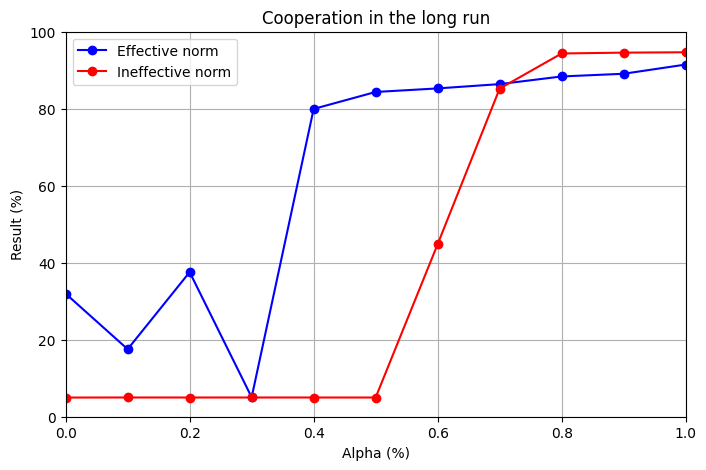

In [50]:
effective_norm =[1,0,0,1]
ineffective_norm = [0,0,0,0]
payoffs = np.array([[0, b],[-c, b-c]])

results_eff = []
results_ineff = []

for i in range(11):
    alpha = i * 0.1
    results_eff.append(run(payoffs, effective_norm, alpha))

for i in range(11):
    alpha = i * 0.1
    results_ineff.append(run(payoffs, ineffective_norm, alpha))

results_eff = np.array(results_eff)
results_eff = results_eff.flatten()*100

results_ineff = np.array(results_ineff)
results_ineff = results_ineff.flatten()*100

x = np.arange(len(results_eff))/10

print(x)
print(results_eff)
print(results_ineff)


plt.figure(figsize=(8, 5))
# Courbe effective (bleu)
plt.plot(
    x,
    results_eff,
    color="blue",
    marker="o",
    label="Effective norm"
)

# Courbe ineffective (rouge)
plt.plot(
    x,
    results_ineff,
    color="red",
    marker="o",
    label="Ineffective norm"
)

# Limites des axes
plt.ylim(0, 100)
plt.xlim(0, 1)

# Labels
plt.xlabel("Alpha (%)")
plt.ylabel("Result (%)")
plt.title("Cooperation in the long run")
plt.legend()
plt.grid(True)

plt.show()
